In [25]:
#Extended CCA from meta BCI
from typing import Optional, Union
from numpy import ndarray
import numpy as np

def generate_cca_references(
    freqs,
    srate,
    T,
    phases: Optional[Union[ndarray, int, float]] = None,
    n_harmonics: int = 1,
):
    if isinstance(freqs, int) or isinstance(freqs, float):
        freqs = [freqs]
    freqs = np.array(freqs)[:, np.newaxis]
    if phases is None:
        phases = 0
    if isinstance(phases, int) or isinstance(phases, float):
        phases = np.array([phases])
    phases = np.array(phases)[:, np.newaxis]
    t = np.linspace(0, T, int(T * srate))

    Yf = []
    for i in range(n_harmonics):
        Yf.append(
            np.stack(
                [
                    np.sin(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                    np.cos(2 * np.pi * (i + 1) * freqs * t + np.pi * phases),
                ],
                axis=1,
            )
        )
    Yf = np.concatenate(Yf, axis=1)
    return Yf

In [26]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from typing import Optional, cast,  List
from joblib import Parallel, delayed
from functools import partial
from scipy.linalg import eigh, pinv, qr
from scipy.stats import pearsonr
from scipy.sparse import block_diag, identity, vstack, spmatrix
from scipy.sparse.linalg import eigsh

def _ged_wong( 
    Z: ndarray,
    D: Optional[ndarray] = None,
    P: Optional[ndarray] = None,
    n_components=1,
    method="type1",
):
    if method != "type1" and method != "type2":
        raise ValueError("not supported method type")

    A = Z
    if D is not None:
        A = D.T @ A
    if P is not None:
        A = P.T @ A
    A = A.T @ A
    if method == "type1":
        B = Z
        if D is not None:
            B = D.T @ Z
        B = B.T @ B
        if isinstance(A, spmatrix) or isinstance(B, spmatrix):
            D, W = eigsh(A, k=n_components, M=B)
        else:
            D, W = eigh(A, B)
    elif method == "type2":
        if isinstance(A, spmatrix):
            D, W = eigsh(A, k=n_components)
        else:
            D, W = eigh(A)

    D_exist = cast(ndarray, D)
    ind = np.argsort(D_exist)[::-1]
    D_exist, W = D_exist[ind], W[:, ind]
    return D_exist[:n_components], W[:, :n_components]


def _ecca_feature(
    X: ndarray,
    templates: ndarray,
    Yf: ndarray,
    Us: Optional[ndarray] = None,
    n_components: int = 1,
):
    if Us is None:
        Us_array, _ = zip(
            *[_scca_kernel(templates[i], Yf[i]) for i in range(len(templates))]
        )
        Us = np.stack(Us_array)
    rhos = []
    for Xk, Y, U3 in zip(templates, Yf, Us):
        rho_list = []
        # 14a, 14d
        U1, V1 = _scca_kernel(X, Y)
        a = U1[:, :n_components].T @ X
        b = V1[:, :n_components].T @ Y
        a, b = np.reshape(a, (-1)), np.reshape(b, (-1))
        rho_list.append(pearsonr(a, b)[0])
        a = U1[:, :n_components].T @ X
        b = U1[:, :n_components].T @ Xk
        a, b = np.reshape(a, (-1)), np.reshape(b, (-1))
        rho_list.append(pearsonr(a, b)[0])
        # 14b
        U2, _ = _scca_kernel(X, Xk)
        a = U2[:, :n_components].T @ X
        b = U2[:, :n_components].T @ Xk
        a, b = np.reshape(a, (-1)), np.reshape(b, (-1))
        rho_list.append(pearsonr(a, b)[0])
        # 14c
        a = U3[:, :n_components].T @ X
        b = U3[:, :n_components].T @ Xk
        a, b = np.reshape(a, (-1)), np.reshape(b, (-1))
        rho_list.append(pearsonr(a, b)[0])
        rho = np.array(rho_list)
        rho = np.sum(np.sign(rho) * (rho**2))
        rhos.append(rho)
    return rhos


def _scca_kernel(X: ndarray, Yf: ndarray):
    """Standard CCA (sCCA).

    This is an time-consuming implementation due to GED.

    X: (n_channels, n_samples)
    Yf: (n_harmonics, n_samples)
    """
    n_components = min(X.shape[0], Yf.shape[0])
    Q, R = qr(Yf.T, mode="economic")
    P = Q @ Q.T
    Z = X.T
    _, U = _ged_wong(Z, None, P, n_components=n_components)  # U for X
    V = pinv(R) @ Q.T @ X.T @ U  # V for Yf
    return U, V


class ECCA(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(self, n_components: int = 1, n_jobs: Optional[int] = None):
        self.n_components = n_components
        self.n_jobs = n_jobs

    def fit(self, X: ndarray, y: ndarray, Yf: ndarray):

        self.classes_ = np.unique(y)
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        self.templates_ = np.stack(
            [np.mean(X[y == label], axis=0) for label in self.classes_]
        )

        Yf = np.reshape(Yf, (-1, *Yf.shape[-2:]))
        Yf = Yf - np.mean(Yf, axis=-1, keepdims=True)
        self.Yf_ = Yf
        self.Us_, self.Vs_ = zip(
            *[
                _scca_kernel(self.templates_[i], self.Yf_[i])
                for i in range(len(self.classes_))
            ]
        )
        self.Us_, self.Vs_ = np.stack(self.Us_), np.stack(self.Vs_)
        return self

    def transform(self, X: ndarray):
        X = np.reshape(X, (-1, *X.shape[-2:]))
        X = X - np.mean(X, axis=-1, keepdims=True)
        templates = self.templates_
        Yf = self.Yf_
        Us = self.Us_
        n_components = self.n_components
        rhos = Parallel(n_jobs=self.n_jobs)(
            delayed(partial(_ecca_feature, Us=Us, n_components=n_components))(
                a, templates, Yf
            )
            for a in X
        )
        rhos = np.stack(rhos)
        return rhos

    def predict(self, X: ndarray):
        rhos = self.transform(X)
        labels = self.classes_[np.argmax(rhos, axis=-1)]
        return labels

In [27]:
list_freqs = [8, 9, 10, 11, 12, 13, 14, 15, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 14.2, 15.2, 8.4, 9.4, 10.4, 11.4, 12.4, 13.4, 14.4, 15.4, 8.6, 9.6, 10.6, 11.6, 12.6, 13.6, 14.6, 15.6, 8.8, 9.8, 10.8, 11.8, 12.8, 13.8, 14.8, 15.8]
list_phases = [0, 1.75, 1.50, 1.25, 1.0, 0.75, 0.50, 0.25, 0.35, 0.10, 1.85, 1.60, 1.35, 1.10, 0.85, 0.60, 0.70, 0.45, 0.20, 1.95, 1.70, 1.45, 1.20, 0.95, 1.05, 0.80, 0.55, 0.30, 0.05, 1.80, 1.55, 1.30, 1.40, 1.15, 0.90, 0.65, 0.40, 0.15, 1.90, 1.65]
char_map = {
  8: 'A',
  9: 'B',
  10: 'C',
  11: 'D',
  12: 'E',
  13: 'F',
  14: 'G',
  15: 'H',
  8.2: 'I',
  9.2: 'J',
  10.2: 'K',
  11.2: 'L',
  12.2: 'M',
  13.2: 'N',
  14.2: 'O',
  15.2: 'P',
  8.4: 'Q',
  9.4: 'R',
  10.4: 'S',
  11.4: 'T',
  12.4: 'U',
  13.4: 'V',
  14.4: 'W',
  15.4: 'X',
  8.6: 'Y',
  9.6: 'Z',
  10.6: '0',
  11.6: '1',
  12.6: '2',
  13.6: '3',
  14.6: '4',
  15.6: '5',
  8.8: '6',
  9.8: '7',
  10.8: '8',
  11.8: '9',
  12.8: ' ',
  13.8: ',',
  14.8: '.',
  15.8: '<-'
}

Opening raw data file sunsun.fif...
    Range : 0 ... 102805 =      0.000 ...   411.220 secs
Ready.
Creating RawArray with float64 data, n_channels=9, n_times=100556
    Range : 0 ... 100555 =      0.000 ...   402.220 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

220 events found
Event IDs: [1]
Not setting metadata
220 matching events found
No baseline correction applied
0 projection items activated
Effective window size : 1.024 (s)


C:\Users\bci\AppData\Local\Temp\ipykernel_9332\3059240731.py:4: RuntimeWarning: This filename (sunsun.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw =  mne.io.read_raw_fif(fname)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\Users\bci\.virtualenvs\hybrid-ssvep-p300-speller-ZL_XZSnA\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplo

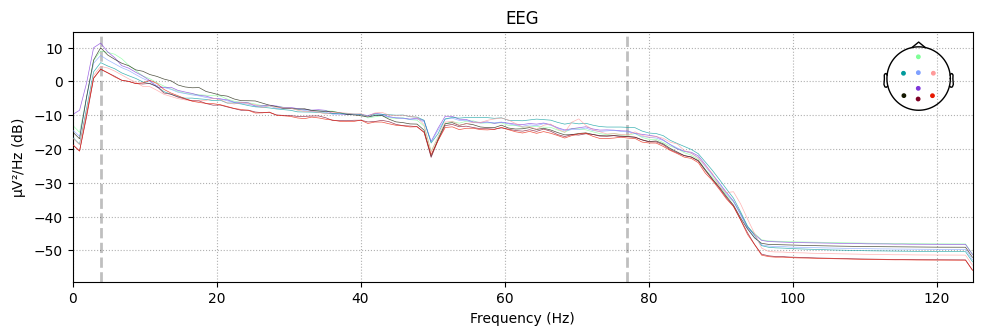

In [28]:
import mne

fname = "sunsun.fif"
raw =  mne.io.read_raw_fif(fname)
new_data = raw.get_data()[:,7*250:-2*250]
raw = mne.io.RawArray(new_data, raw.info)
raw.notch_filter([50,100])
events = mne.find_events(raw)
epochs = mne.Epochs(raw=raw,events=events, baseline=None, tmin=0, tmax=2.7, reject=None, reject_by_annotation=False)
raw.compute_psd().plot()

In [29]:
amp = 1e-5
duration = int(250 * 0.5)
offset_1 = 150
offset_2 = 150 + duration

In [30]:
import matplotlib.pyplot as plt
#Preparing data for the extended CCA
data = epochs.get_data()
samples = data[0][0].size - 1
print(samples)
eeg_ch = 8
# X = []
# f = 8
t = np.arange(0,1,1/samples)
# p = np.pi * 0
X_train = []
y_train = []

for index, (f , p) in enumerate(zip(list_freqs * 5, list_phases * 5)):
    p = np.pi * p
    X = []
    for ch_idx in range(eeg_ch):
        s = data[index][ch_idx][:-1]
        signal = s 
        for N in range(1,5):
            ssvep = ((amp * np.sin((2 * np.pi * N * f * t) + p))) * 1/N
            # signal[150:150+250] = signal[150:150+250] + ssvep[:250]
            signal[offset_1: offset_2] = signal[offset_1: offset_2] + ssvep[:duration]
        X.append(signal.reshape(1,-1))

    X = np.vstack(X)
    # plt.plot(X.T)
    # plt.show()  
    X_train.append(X)
    y_train.append(char_map[f])

X_train = np.dstack(X_train)
X_train = np.swapaxes(X_train, 0, 2)
X_train = np.swapaxes(X_train, 1, 2)
y_train = np.array(y_train)
print(y_train.shape)

Using data from preloaded Raw for 220 events and 676 original time points ...
1 bad epochs dropped
675
(200,)


Opening raw data file sunsun_v2.fif...
    Range : 0 ... 103950 =      0.000 ...   415.800 secs
Ready.
Creating RawArray with float64 data, n_channels=9, n_times=101701
    Range : 0 ... 101700 =      0.000 ...   406.800 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

223 events found
Event IDs: [1]
Not setting metadata
223 matching events found
No baseline correction applied
0 projection items activated
Effective window size : 1.024 (s)


C:\Users\bci\AppData\Local\Temp\ipykernel_9332\4010049257.py:2: RuntimeWarning: This filename (sunsun_v2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_test =  mne.io.read_raw_fif(fname)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\Users\bci\.virtualenvs\hybrid-ssvep-p300-speller-ZL_XZSnA\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module:

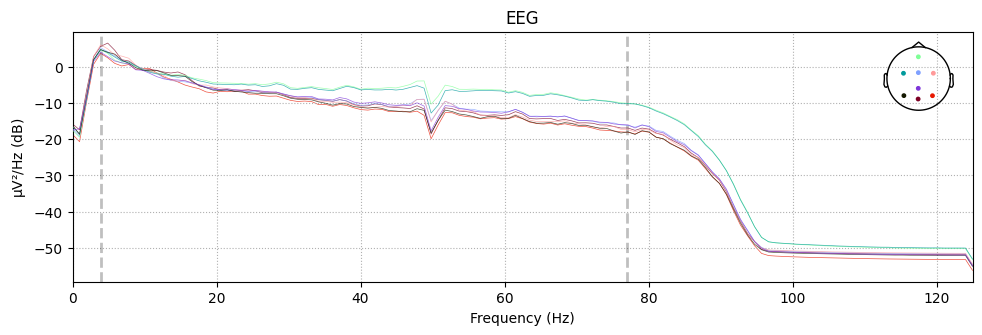

In [31]:
fname = "sunsun_v2.fif"
raw_test =  mne.io.read_raw_fif(fname)
new_data = raw_test.get_data()[:,7*250:-2*250]
raw_test = mne.io.RawArray(new_data, raw.info)
raw_test.notch_filter([50,100])
events_test = mne.find_events(raw_test)
epochs_test = mne.Epochs(raw=raw_test,events=events_test, baseline=None, tmin=0, tmax=2.7, reject=None, reject_by_annotation=False)

raw_test.compute_psd().plot()

In [32]:
data_test = epochs_test.get_data()
samples = data_test[0][0].size - 1
print(samples)
eeg_ch = 8
# X = []
# f = 8
t = np.arange(0,1,1/samples)
# p = np.pi * 0
X_test = []
y_test = []

for index, (f , p) in enumerate(zip(list_freqs * 5, list_phases * 5)):
    p = np.pi * p
    X = []
    for ch_idx in range(eeg_ch):
        s = data_test[index][ch_idx][:-1]
        signal = s 
        for N in range(1,5):
            ssvep = ((amp * np.sin((2 * np.pi * N * f * t) + p))) * 1/N
            signal[offset_1: offset_2] = signal[offset_1: offset_2] + ssvep[:duration]
        X.append(signal.reshape(1,-1))

    X = np.vstack(X)
    # plt.plot(X.T)
    # plt.show()  
    X_test.append(X)
    y_test.append(char_map[f])
    # break

X_test = np.dstack(X_test)
X_test = np.swapaxes(X_test, 0, 2)
X_test = np.swapaxes(X_test, 1, 2)
y_test = np.array(y_test)
print(y_test.shape)

Using data from preloaded Raw for 223 events and 676 original time points ...
1 bad epochs dropped
675
(200,)


In [33]:
from sklearn.utils import shuffle

Yf = generate_cca_references(freqs=list_freqs, srate=250, T=2.7, phases=list_freqs, n_harmonics=5)

estimator=ECCA(n_components = 1, n_jobs=-1)
# X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=0.3)
model = estimator.fit(X_train, y_train, Yf)
X_test, y_test = shuffle(X_test, y_test)
preds = model.predict(X_test)
acc = np.mean(preds==y_test)
print(preds)
print(y_test)
print(acc)

['A' 'H' 'V' '9' '6' 'P' 'W' 'O' 'Y' '4' '<-' ',' 'N' ',' '6' 'Q' 'L' 'O'
 '9' 'C' 'Y' '9' 'Y' 'E' 'O' 'H' '4' 'H' 'P' 'C' 'U' '<-' 'H' 'T' 'T' 'W'
 '6' 'S' 'L' 'Z' 'V' 'F' 'Q' 'P' 'I' 'E' 'X' 'I' 'F' 'Z' '3' 'C' '2' ' '
 'R' '1' '7' 'M' 'D' 'X' 'L' '1' '8' ' ' '1' 'C' ' ' 'K' 'H' 'Z' '0' 'V'
 'I' '8' '<-' '2' '8' '.' 'N' 'Q' '7' '5' 'S' 'H' '5' '5' '0' 'B' '8' 'A'
 'T' 'M' 'H' 'Z' '5' ' ' '4' 'D' 'I' ' ' '<-' 'N' '7' 'F' '<-' ' ' '0' '1'
 '3' 'R' 'Z' 'E' 'M' '5' '5' '2' 'N' 'V' 'T' '9' 'U' 'I' 'E' 'A' 'K' '2'
 'D' 'M' '.' 'E' 'O' 'L' '.' ' ' '8' '.' 'I' 'D' 'L' '0' ',' ',' 'T' 'M'
 '4' '<-' 'A' 'J' 'F' '5' 'O' 'B' 'Y' 'X' 'F' 'S' 'W' 'A' 'M' '7' 'S' 'P'
 'Z' '0' '8' '7' '6' 'F' 'A' '7' '<-' 'S' 'J' 'S' '4' 'M' 'L' '5' '4' 'U'
 'P' 'X' '1' 'W' 'I' 'L' 'S' 'B' '3' 'U' 'E' 'C' 'X' 'V' 'R' 'U' 'W' 'X'
 '0' 'Q']
['A' 'H' 'V' '9' '7' 'P' 'W' 'O' 'Y' '4' '<-' ',' 'N' ',' '6' 'Q' 'K' 'N'
 '9' 'C' 'Y' '9' 'Y' 'E' 'O' 'G' '4' 'G' 'P' 'C' 'U' '.' 'H' 'U' 'T' 'W'
 '6' 'S' 'L' 'G' 'V' 'F' 'Q' 'P' 

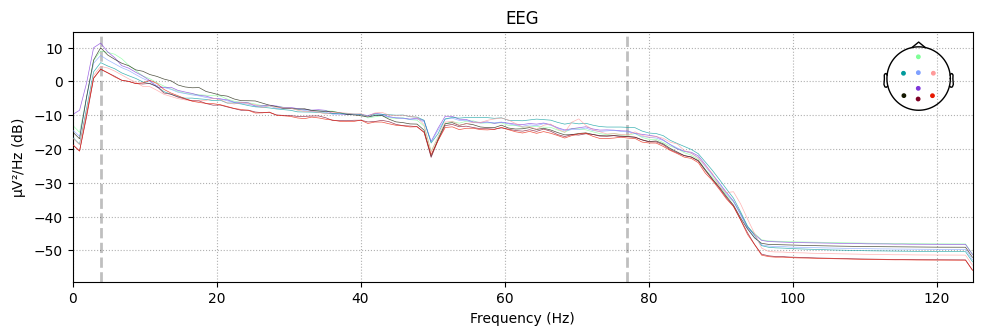

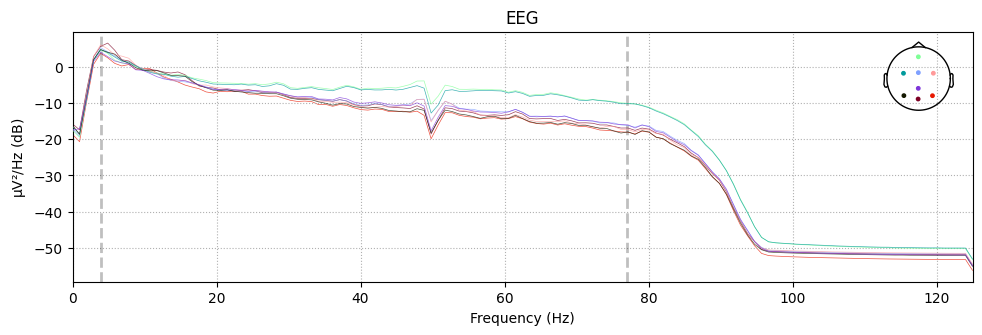

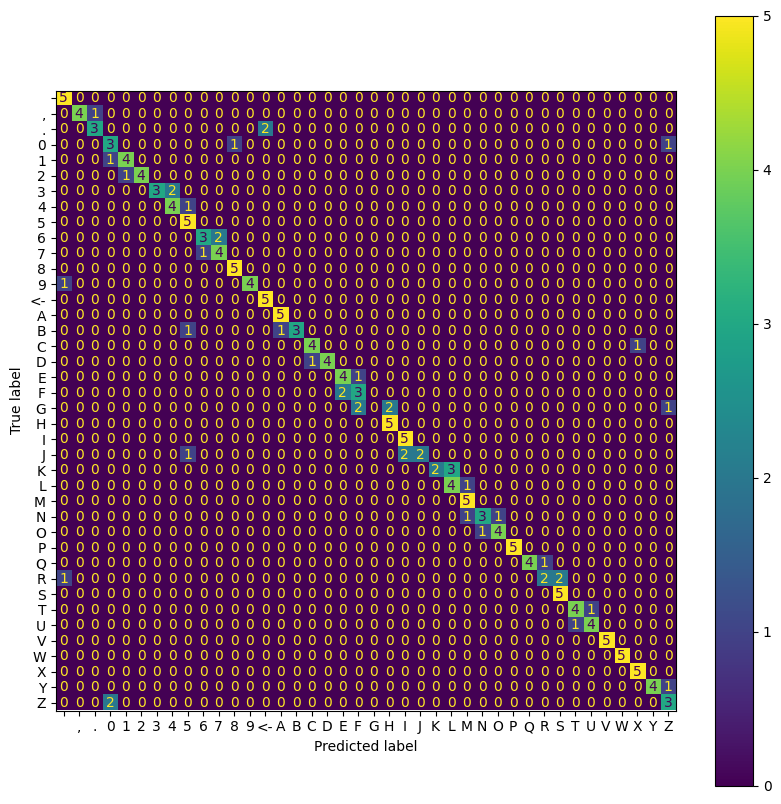

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test, preds)
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)
plt.show()

In [35]:
import pickle

# save the model to disk
filename = 'finalized_model_ECCA.sav'
pickle.dump(model, open(filename, 'wb'))

In [36]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.775
